# Heston Model for Stochastic Volatility

## Heston Model SDE

Underlying process: $dS_{t} = rS_{t}dt + \sqrt{v_{t}}S_{t}dW_{S,t}^\mathbb{P}$

Variance process: $dv_{t} = \kappa(\theta - v_{t})dt + \sigma\sqrt{v_{t}}dW_{v,t}^\mathbb{P}$

$- dW_{S,t}^\mathbb{P} = $ Brownian motion of asset price

$- dW_{v,t}^\mathbb{P} = $ Brownian motion of asset's price variance

$- \rho^\mathbb{P} = $ correlation between $dW_{S,t}^\mathbb{Q}$ and $dW_{v,t}^\mathbb{Q}$

### Euler Discretisation of SDEs

$dS_{i+1}=S_{i}e^{(r-\frac{v_{i}}{2})\Delta t} + \sqrt{v_{i}}\Delta t W_{S, i+1}^\mathbb{Q}$

$v_{i+1}=v_{i}+\kappa(\theta-v_{t})\Delta t + \sigma \sqrt{v_{i}}\Delta t W_{v, i+1}^\mathbb{Q}$

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

In [3]:
# Simulation-dependent parameters
S0 = 100.0
T = 1.0
r = 0.02
N = 252
M = 100000

# Heston-dependent parameters
kappa = 3
theta = 0.20**2
v0 = 0.25**2
rho = 0.7
sigma = 0.6

theta, v0

(0.04000000000000001, 0.0625)

### Monte Carlo Simulation

In [7]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M): 
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1, rho], [rho, 1]])
    
    # Starting prices and variances 
    S = np.full(shape=(N+1, M), fill_value=S0)
    v = np.full(shape =(N+1, M), fill_value=v0)
    
    # Sampling correlated Brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))
    
    for i in range(1, N+1):
        S[i] = S[i-1] * np.exp((r - 0.5*v[i-1])*dt + np.sqrt(v[i-1]*dt) * Z[i-1,:,0])
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt) * Z[i-1,:,1],0)
        
    return S, v 

In [8]:
rho_p = 0.98
rho_n = -0.98

S_p, v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma, T, N, M)
S_n, v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma, T, N, M)

### Plotting the asset prices and variance over time

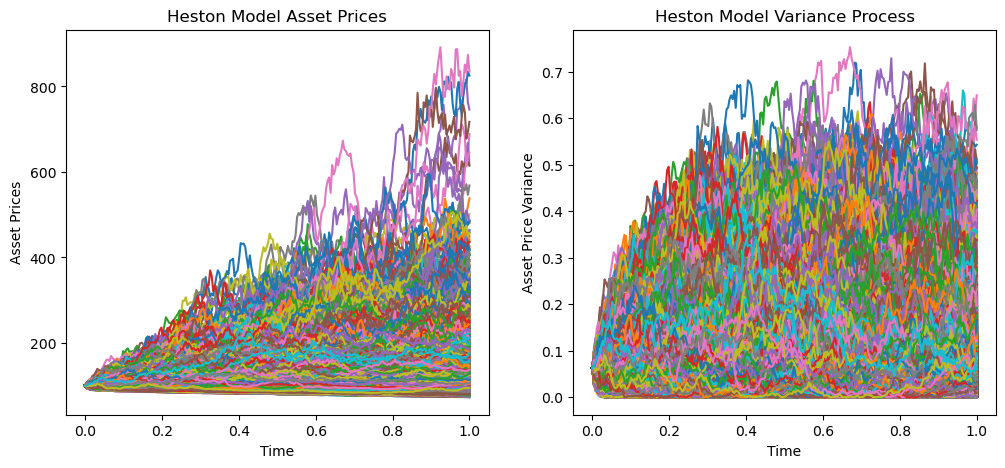

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
time = np.linspace(0, T, N+1)
ax1.plot(time, S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time, v_p)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Asset Price Variance')

plt.show()

### Asset Price distribution with different correlations

In [11]:
# simulating GBM process at time T
gbm = S0*np.exp((r - theta**2/2)*T + np.sqrt(theta)*np.sqrt(T)*np.random.normal(0,1,M))

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


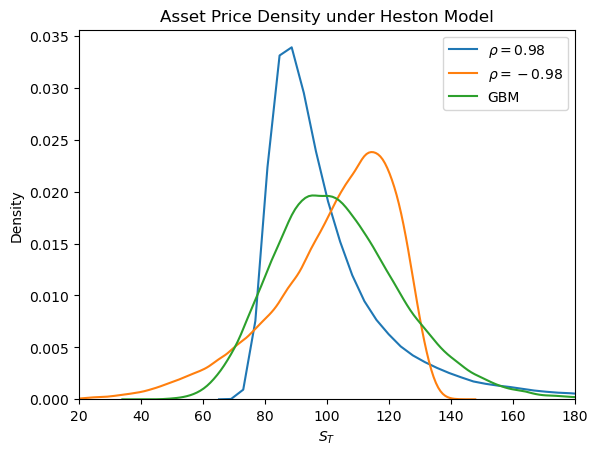

In [14]:
fig, ax = plt.subplots()

ax = sns.kdeplot(S_p[-1], label=r"$\rho = 0.98$", ax=ax)
ax = sns.kdeplot(S_n[-1], label=r"$\rho = -0.98$", ax=ax)
ax = sns.kdeplot(gbm, label="GBM", ax=ax)

plt.title(r'Asset Price Density under Heston Model')
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

### Volatility Smile in Option Pricing

In [15]:
rho = -0.7
S,v = heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M)

In [18]:
# Set strikes and complete simulated option price for different strikes
K = np.arange(20, 180, 2)

puts = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S, 0)) for k in K])
calls = np.array([np.exp(-r*T)*np.mean(np.maximum(S-k, 0)) for k in K])

put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')

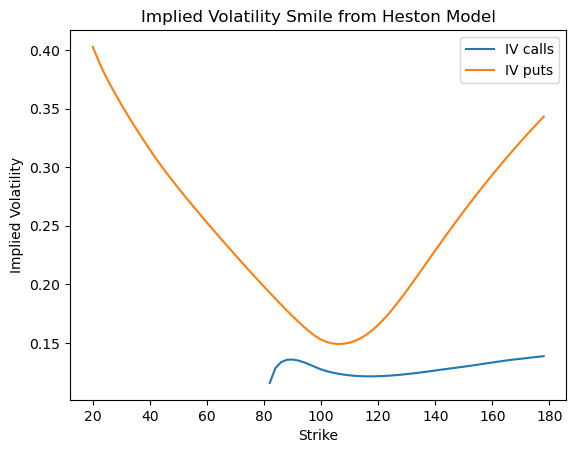

In [19]:
plt.plot(K, call_ivs, label=r'IV calls')
plt.plot(K, put_ivs, label=r'IV puts')

plt.ylabel('Implied Volatility')
plt.xlabel('Strike')

plt.title('Implied Volatility Smile from Heston Model')
plt.legend()
plt.show()